In [ ]:
!pip install tabulate


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [00:31<00:00, 107MB/s]
100% 1.98G/1.98G [00:31<00:00, 68.0MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/fruit-and-vegetable-image-recognition')


In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

warnings.filterwarnings("ignore")

In [ ]:
import os

base_dir = '/content/fruit-and-vegetable-image-recognition'
for dirpath, dirnames, filenames in os.walk(base_dir):
    print(f'Found directory: {dirpath}, containing files: {len(filenames)}')


Found directory: /content/fruit-and-vegetable-image-recognition, containing files: 0
Found directory: /content/fruit-and-vegetable-image-recognition/train, containing files: 0
Found directory: /content/fruit-and-vegetable-image-recognition/train/cauliflower, containing files: 79
Found directory: /content/fruit-and-vegetable-image-recognition/train/mango, containing files: 86
Found directory: /content/fruit-and-vegetable-image-recognition/train/sweetcorn, containing files: 91
Found directory: /content/fruit-and-vegetable-image-recognition/train/pomegranate, containing files: 79
Found directory: /content/fruit-and-vegetable-image-recognition/train/soy beans, containing files: 97
Found directory: /content/fruit-and-vegetable-image-recognition/train/peas, containing files: 100
Found directory: /content/fruit-and-vegetable-image-recognition/train/corn, containing files: 87
Found directory: /content/fruit-and-vegetable-image-recognition/train/bell pepper, containing files: 90
Found directory

In [ ]:
# Verify the directory structure
base_dir = '/content/fruit-and-vegetable-image-recognition'
for dirpath, dirnames, filenames in os.walk(base_dir):
    print(f'Found directory: {dirpath}, containing files: {len(filenames)}')

base_dir = Path('/content/fruit-and-vegetable-image-recognition')
train_dir = base_dir / 'train'
test_dir = base_dir / 'test'
val_dir = base_dir / 'validation'

def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

print(f"Number of training images found: {len(train_filepaths)}")
print(f"Number of testing images found: {len(test_filepaths)}")
print(f"Number of validation images found: {len(val_filepaths)}")

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

Found directory: /content/fruit-and-vegetable-image-recognition, containing files: 0
Found directory: /content/fruit-and-vegetable-image-recognition/train, containing files: 0
Found directory: /content/fruit-and-vegetable-image-recognition/train/cauliflower, containing files: 79
Found directory: /content/fruit-and-vegetable-image-recognition/train/mango, containing files: 86
Found directory: /content/fruit-and-vegetable-image-recognition/train/sweetcorn, containing files: 91
Found directory: /content/fruit-and-vegetable-image-recognition/train/pomegranate, containing files: 79
Found directory: /content/fruit-and-vegetable-image-recognition/train/soy beans, containing files: 97
Found directory: /content/fruit-and-vegetable-image-recognition/train/peas, containing files: 100
Found directory: /content/fruit-and-vegetable-image-recognition/train/corn, containing files: 87
Found directory: /content/fruit-and-vegetable-image-recognition/train/bell pepper, containing files: 90
Found directory

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')


-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['chilli pepper' 'peas' 'soy beans' 'sweetcorn' 'watermelon' 'garlic'
 'pear' 'pomegranate' 'apple' 'bell pepper' 'lettuce' 'beetroot' 'potato'
 'ginger' 'jalepeno' 'tomato' 'pineapple' 'banana' 'corn' 'turnip'
 'capsicum' 'onion' 'spinach' 'eggplant' 'carrot' 'cabbage' 'paprika'
 'kiwi' 'mango' 'cauliflower' 'grapes' 'cucumber' 'lemon' 'sweetpotato'
 'raddish' 'orange']


In [ ]:
train_df.head(5)

Filepath          Label
0  /content/fruit-and-vegetable-image-recognition...  chilli pepper
1  /content/fruit-and-vegetable-image-recognition...           peas
2  /content/fruit-and-vegetable-image-recognition...      soy beans
3  /content/fruit-and-vegetable-image-recognition...      sweetcorn
4  /content/fruit-and-vegetable-image-recognition...     watermelon

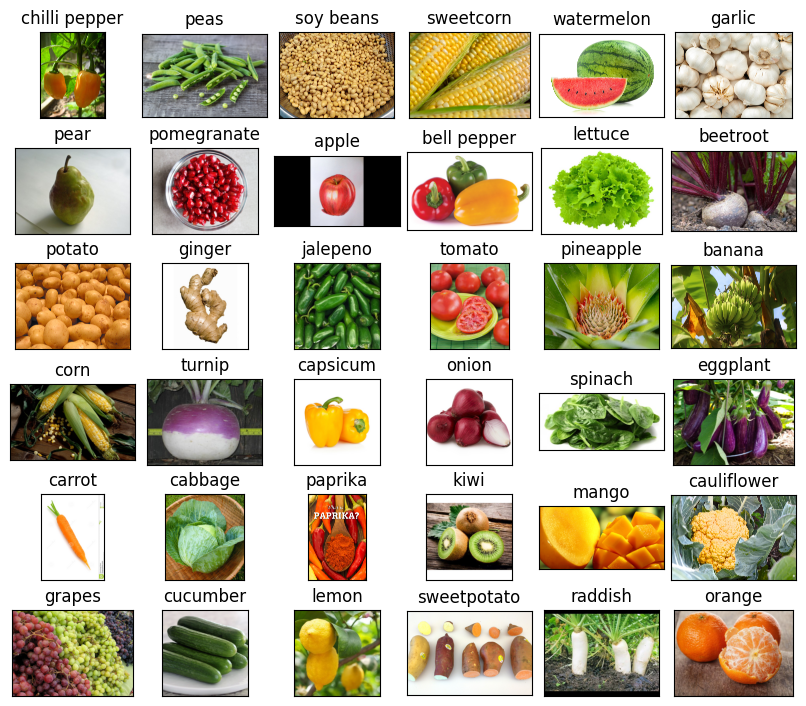

In [ ]:
# Display some sample images
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img_path = df_unique.iloc[i]["Filepath"]
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(df_unique.iloc[i]["Label"], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:

# Data generators
train_labels = train_df['Label']
val_labels = val_df['Label']

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(len(train_df['Label'].unique()), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
87/87 [==============================] - 249s 3s/step - loss: 2.1875 - accuracy: 0.4187 - val_loss: 0.7018 - val_accuracy: 0.8054
Epoch 2/10
87/87 [==============================] - 228s 3s/step - loss: 1.0519 - accuracy: 0.6975 - val_loss: 0.4452 - val_accuracy: 0.8743
Epoch 3/10
87/87 [==============================] - 238s 3s/step - loss: 0.7933 - accuracy: 0.7518 - val_loss: 0.3685 - val_accuracy: 0.8952
Epoch 4/10
87/87 [==============================] - 228s 3s/step - loss: 0.6812 - accuracy: 0.7820 - val_loss: 0.3232 - val_accuracy: 0.9162
Epoch 5/10
87/87 [==============================] - 225s 3s/step - loss: 0.6005 - accuracy: 0.8112 - val_loss: 0.2933 - val_accuracy: 0.9162
Epoch 6/10
87/87 [==============================] - 253s 3s/step - loss: 0.5367 - accuracy: 0.8191 - val_loss: 0.2660 - val_accuracy: 0.9162
Epoch 7/10
87/87 [==============================] - 231s 3s/step - loss: 0.4864 - accuracy: 0.8381 - val_loss: 0.2354 - val_accuracy: 0.9281
Epoch 8/10
87

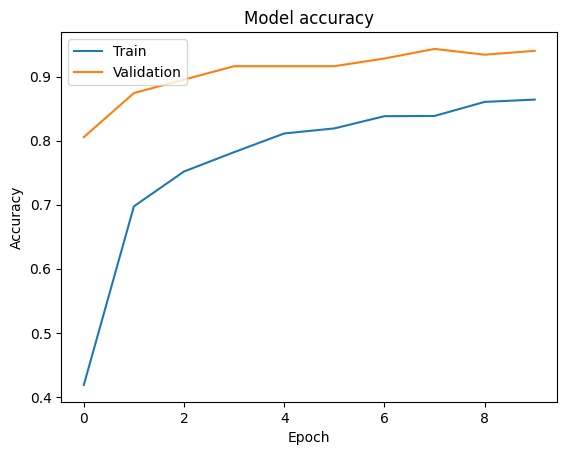

In [15]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

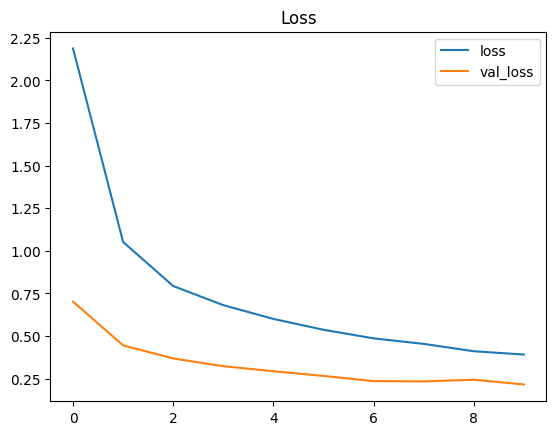

In [16]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
calorie_count = {
    'apple': 52,
    'banana': 89,
    'carrot': 41,
    'orange': 47,
    'broccoli': 34,
    'tomato': 18,
    'strawberry': 32,
    'grapes': 69,
    'watermelon': 30,
    'blueberry': 57,
    'mango': 60,
    'pear': 57,
    'pineapple': 50,
    'cucumber': 16,
    'lettuce': 15,
    'spinach': 23,
    'potato': 77,
    'onion': 40,
    'garlic': 149,
    'pepper': 40,
    'kiwi': 61,
    'avocado': 160,
    'cherry': 50,
    'peach': 39,
    'plum': 46,
    'pomegranate': 83,
    'cabbage': 25,
    'cauliflower': 25,
    'eggplant': 25,
    'celery': 16,
    'radish': 16,
    'beetroot': 43,
    'pumpkin': 26,
    'zucchini': 17,
    'Capsicum' : 20 ,
    'Corn': 86 ,
    'Guava': 68 ,
    'Jalapeño': 29,
    'Lemon': 29 ,
    'Turnip': 28 ,
    'Soybeans': 173,
    'Peas': 81,
    'Sweet corn': 86,
    'Sweet potato': 86,
    'Papaya': 43
    # Add more items as needed
}

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_generator.classes]

print("Predicted labels:", pred)
print("True labels:", y_test)

Found 334 validated image filenames belonging to 36 classes.
11/11 [==============================] - 26s 2s/step
Predicted labels: ['watermelon', 'turnip', 'lemon', 'eggplant', 'potato', 'chilli pepper', 'spinach', 'cauliflower', 'pear', 'mango', 'garlic', 'jalepeno', 'tomato', 'banana', 'lettuce', 'cabbage', 'bell pepper', 'ginger', 'watermelon', 'garlic', 'grapes', 'watermelon', 'grapes', 'grapes', 'orange', 'pineapple', 'ginger', 'sweetcorn', 'cauliflower', 'orange', 'sweetcorn', 'chilli pepper', 'watermelon', 'raddish', 'potato', 'peas', 'kiwi', 'carrot', 'spinach', 'ginger', 'paprika', 'cucumber', 'turnip', 'chilli pepper', 'eggplant', 'bell pepper', 'sweetcorn', 'turnip', 'lettuce', 'eggplant', 'sweetpotato', 'pomegranate', 'turnip', 'cucumber', 'spinach', 'capsicum', 'pomegranate', 'carrot', 'raddish', 'orange', 'cauliflower', 'mango', 'mango', 'kiwi', 'garlic', 'cucumber', 'eggplant', 'paprika', 'chilli pepper', 'pear', 'pear', 'onion', 'kiwi', 'paprika', 'tomato', 'paprika', 

In [19]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 94.01%


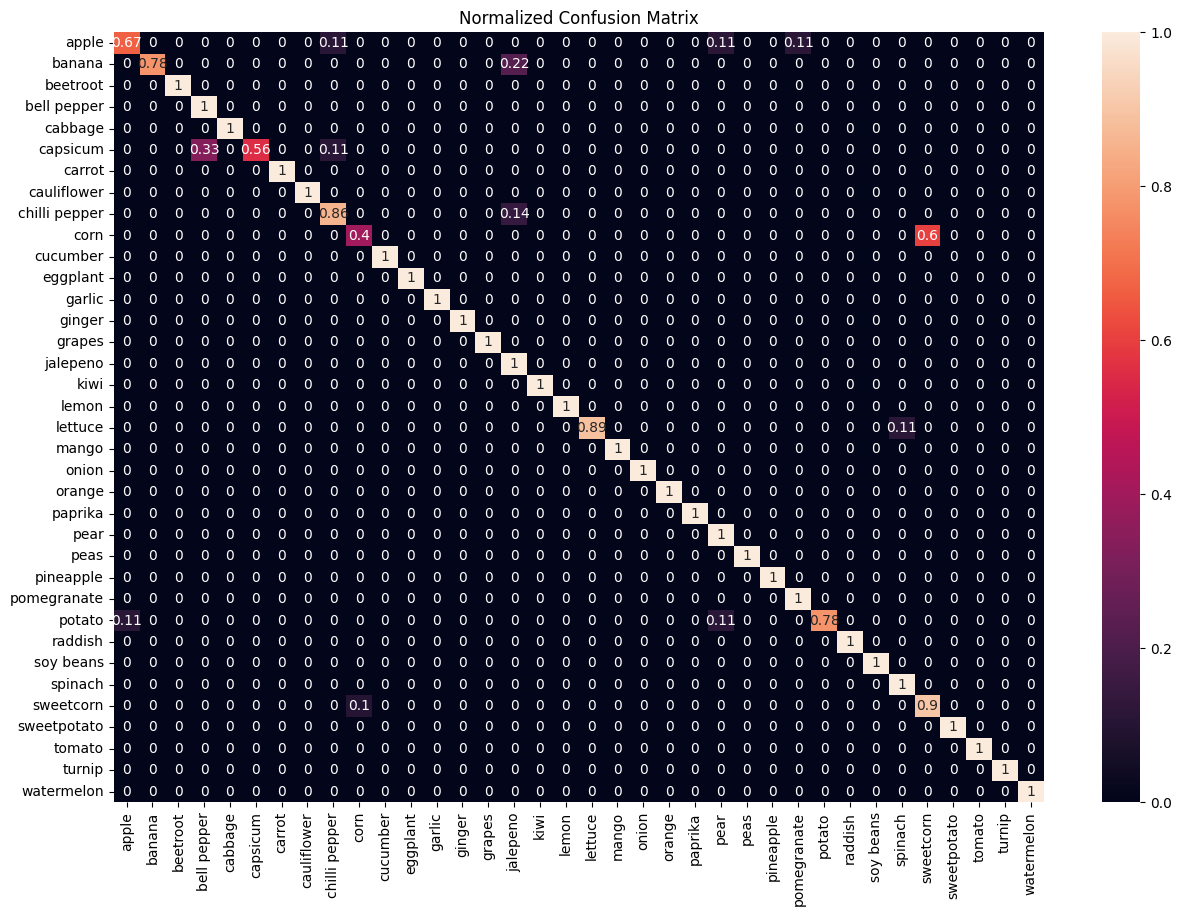

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

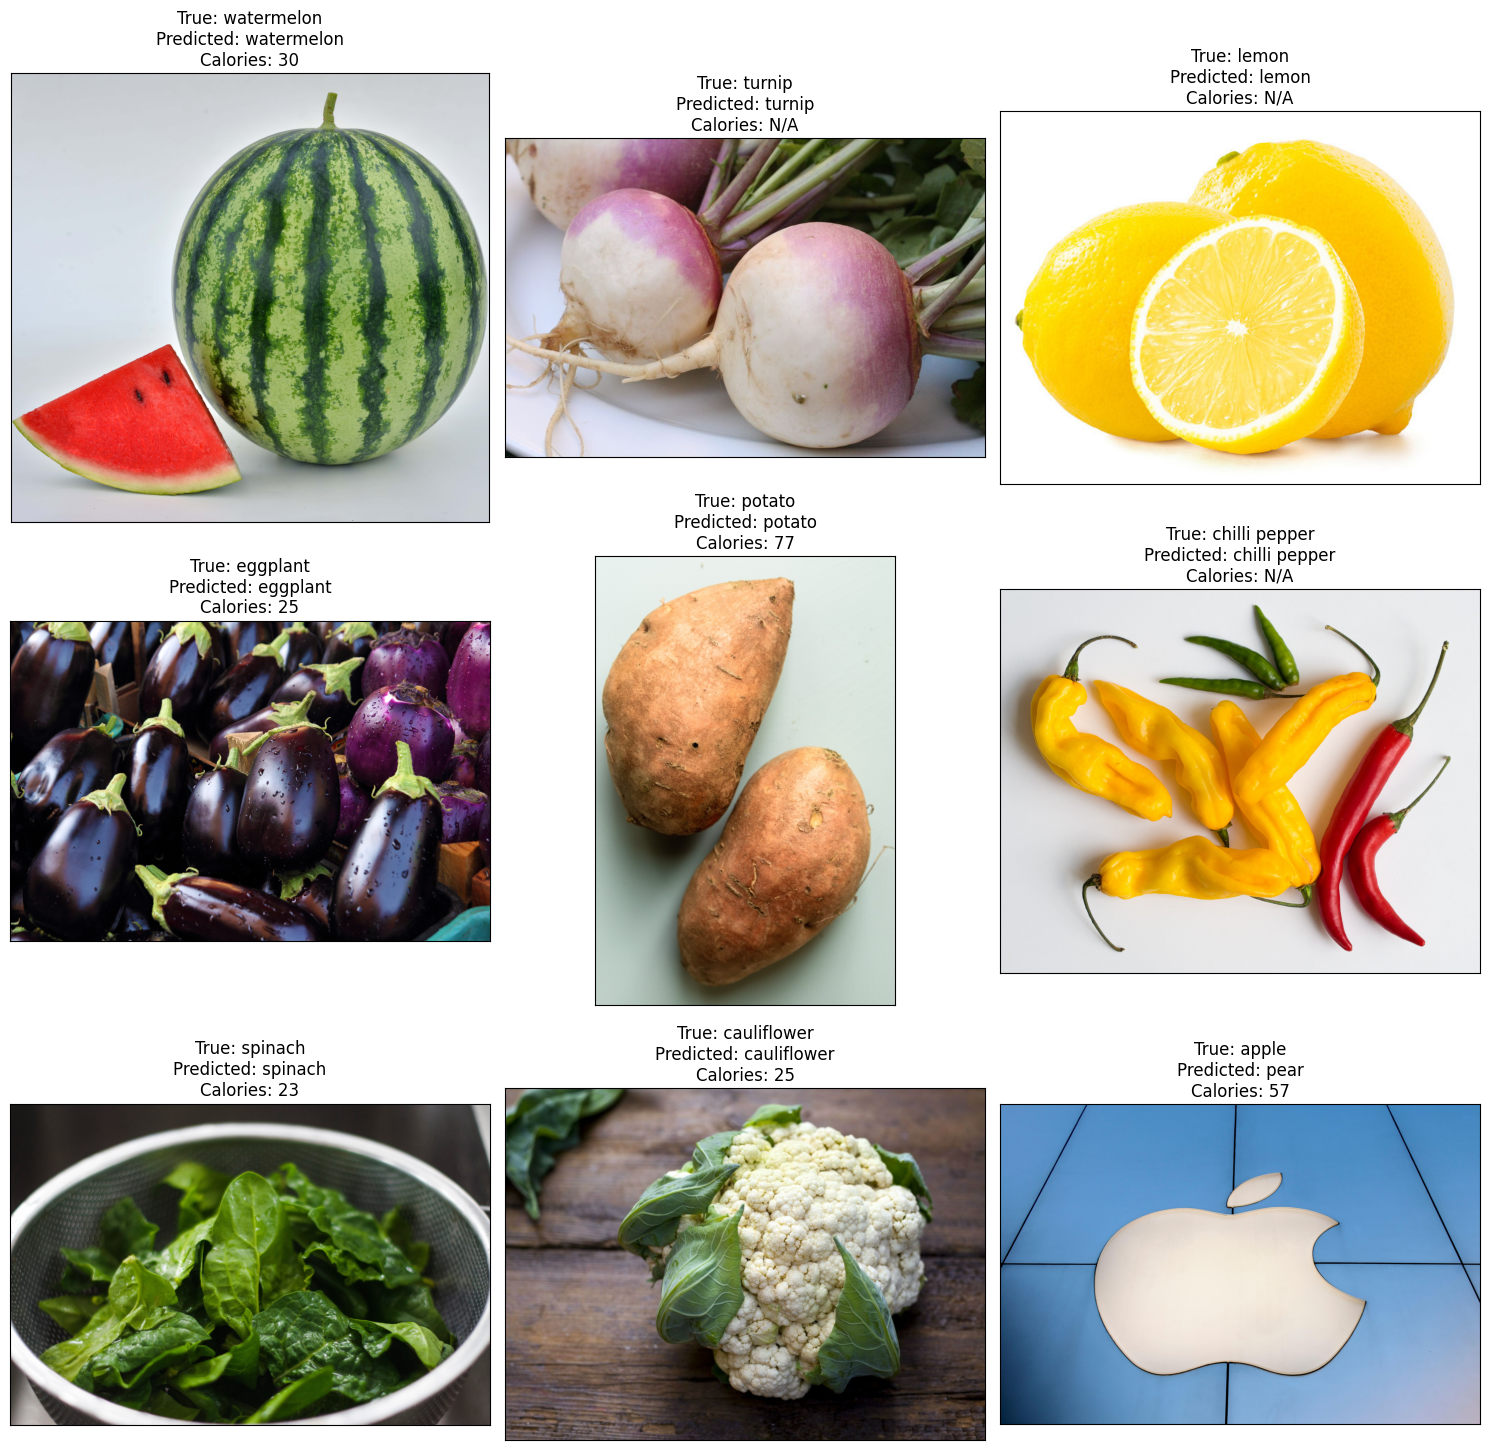

In [21]:
# Visualize predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    true_label = test_df.Label.iloc[i]
    predicted_label = pred[i]
    calorie = calorie_count.get(predicted_label, "N/A")
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}\nCalories: {calorie}")
plt.tight_layout()
plt.show()

In [22]:
# Grad-CAM
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()











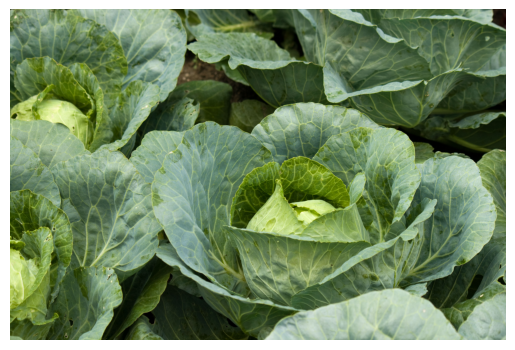

In [26]:
# Display an image from the testing dataset
def display_image(image_path):
    if not os.path.exists(image_path):
        print(f"File {image_path} does not exist.")
        return
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image {image_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for Matplotlib display
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/fruit-and-vegetable-image-recognition/test/cabbage/Image_2.jpg'
display_image(image_path)
